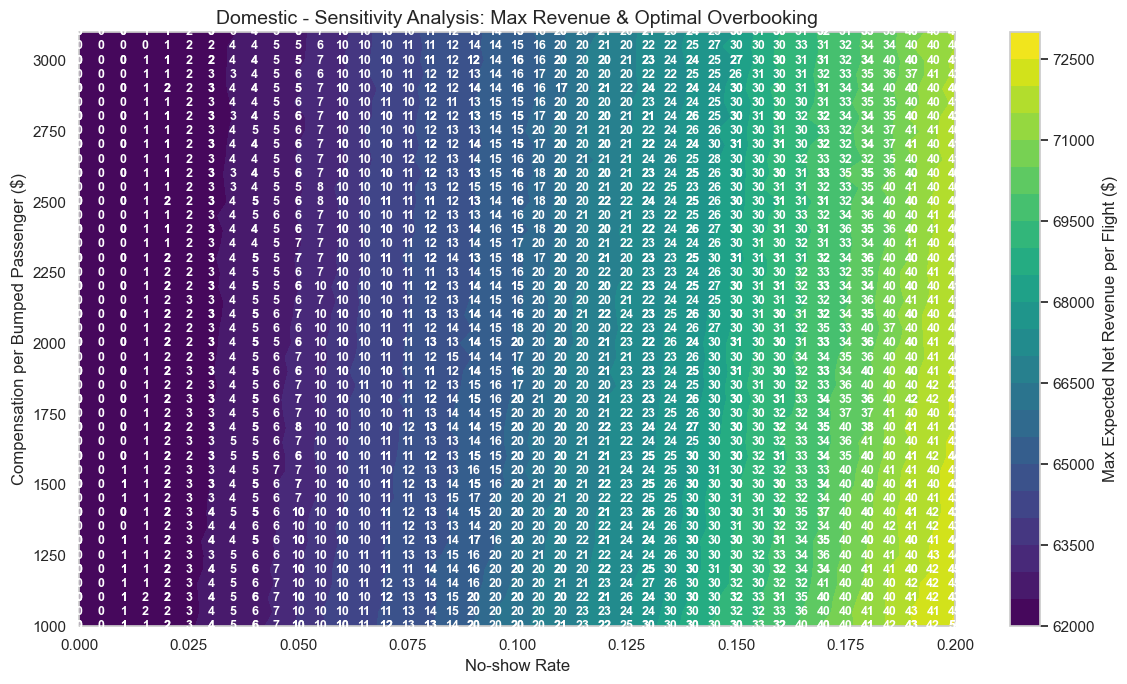

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Core Parameters
num_flights = 1000
seats_per_flight = 200
num_simulations = 1000

# Ticket prices
economy_price = 200
business_price = 4 * economy_price
first_price = 6 * economy_price

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Grid Parameters for Sensitivity Analysis
no_show_rates_to_test = np.round(np.linspace(0.00, 0.20, 41), 3)
compensations_to_test = np.arange(1000, 3101, 50)
booking_levels_to_test = range(seats_per_flight, seats_per_flight + 99)

# Simulation function
def run_simulation_modified(booked_per_flight, seats, economy_tickets, business_tickets, first_tickets, no_show_rate, compensation_per_passenger):
    show_up = np.random.binomial(booked_per_flight, 1 - no_show_rate, num_flights)
    overbooked_per_flight = np.maximum(0, show_up - seats)
    total_overbooked_passengers_today = np.sum(overbooked_per_flight)

    total_economy_revenue = economy_tickets * economy_price * num_flights
    total_business_revenue = business_tickets * business_price * num_flights
    total_first_revenue = first_tickets * first_price * num_flights
    total_potential_revenue_today = total_economy_revenue + total_business_revenue + total_first_revenue

    total_compensation_cost_today = compensation_per_passenger * total_overbooked_passengers_today
    net_revenue_today = total_potential_revenue_today - total_compensation_cost_today

    return net_revenue_today / num_flights

# Sensitivity Analysis Loop
results_list = []
for current_compensation in compensations_to_test:
    for current_no_show_rate in no_show_rates_to_test:
        max_revenue_for_scenario = float('-inf')
        best_booking_level_for_scenario = seats_per_flight

        for booked_per_flight in booking_levels_to_test:
            base_economy = int(0.85 * seats_per_flight)
            base_business = int(0.10 * seats_per_flight)
            base_first = int(0.05 * seats_per_flight)

            extra_seats = max(0, booked_per_flight - seats_per_flight)
            extra_business_intended = int(0.10 * extra_seats)
            extra_economy_intended = extra_seats - extra_business_intended
            extra_first_intended = 0

            current_economy_tickets = base_economy + extra_economy_intended
            current_business_tickets = base_business + extra_business_intended
            current_first_tickets = base_first + extra_first_intended

            avg_net_revenue = run_simulation_modified(
                booked_per_flight,
                seats_per_flight,
                current_economy_tickets,
                current_business_tickets,
                current_first_tickets,
                current_no_show_rate,
                current_compensation
            )

            if avg_net_revenue > max_revenue_for_scenario:
                max_revenue_for_scenario = avg_net_revenue
                best_booking_level_for_scenario = booked_per_flight

        optimal_overbooking_amount = best_booking_level_for_scenario - seats_per_flight
        results_list.append({
            'No-show Rate': current_no_show_rate,
            'Compensation ($)': current_compensation,
            'Optimal Booking Level': best_booking_level_for_scenario,
            'Optimal Overbooking Amount': optimal_overbooking_amount,
            'Max Expected Net Revenue ($)': max_revenue_for_scenario
        })

# DataFrame with results
results_df = pd.DataFrame(results_list)

# Reshape data for plotting
revenue_pivot = results_df.pivot_table(index='Compensation ($)', columns='No-show Rate', values='Max Expected Net Revenue ($)')
overbooking_pivot = results_df.pivot_table(index='Compensation ($)', columns='No-show Rate', values='Optimal Overbooking Amount')

X, Y = np.meshgrid(revenue_pivot.columns, revenue_pivot.index)
Z_revenue = revenue_pivot.values
Z_overbooking = overbooking_pivot.values

# Plotting
plt.figure(figsize=(12, 7))
contour = plt.contourf(X, Y, Z_revenue, cmap='viridis', levels=25)
cbar = plt.colorbar(contour)
cbar.set_label('Max Expected Net Revenue per Flight ($)', fontsize=12)

for i in range(len(compensations_to_test)):
    for j in range(len(no_show_rates_to_test)):
        overbooking_val = int(Z_overbooking[i, j])
        plt.text(X[i, j], Y[i, j], str(overbooking_val), ha='center', va='center', fontsize=9, color='white', weight='bold')

# Make the labels more frequent by adjusting their positioning
for i in range(0, len(compensations_to_test), 2):  # Adjusting the steps to label more points
    for j in range(0, len(no_show_rates_to_test), 2):  # Same here
        overbooking_val = int(Z_overbooking[i, j])
        plt.text(X[i, j], Y[i, j], str(overbooking_val),
                 ha='center', va='center', fontsize=9, color='white', weight='bold')
        
plt.title('Domestic - Sensitivity Analysis: Max Revenue & Optimal Overbooking', fontsize=14)
plt.xlabel('No-show Rate', fontsize=12)
plt.ylabel('Compensation per Bumped Passenger ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [73]:
df = results_df
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.columns


Index(['no-show_rate', 'compensation_($)', 'optimal_booking_level',
       'optimal_overbooking_amount', 'max_expected_net_revenue_($)'],
      dtype='object')

In [74]:

from tabulate import tabulate

# Define the specific no-show rates and compensations to filter for
filters = [
    {'no_show_rate': 0.02, 'compensation': 3000, 'flight_type': 'Holiday Weekends, Business flights'},
    {'no_show_rate': 0.05, 'compensation': 2000, 'flight_type': 'Weekday early mornings'},
    {'no_show_rate': 0.10, 'compensation': 1600, 'flight_type': 'Bad weather flights, Vacations'},
    {'no_show_rate': 0.15, 'compensation': 1200, 'flight_type': 'Red-Eye (Overnight), Budget flights'}
]

# List to store the results
results = []

# Loop through the filters and extract data
for filter_ in filters:
    filtered_df = df[(df["no-show_rate"] == filter_['no_show_rate']) & (df["compensation_($)"] == filter_['compensation'])]
    
    if not filtered_df.empty:
        flight_type = filter_['flight_type']
        optimal_booking_level = filtered_df["optimal_booking_level"].iloc[0]
        max_revenue = filtered_df["max_expected_net_revenue_($)"].iloc[0]
        
        # Store the result in the results list
        results.append([
            flight_type,
            f"{filter_['no_show_rate']*100}%",
            f"${filter_['compensation']}",
            optimal_booking_level,
            f"${max_revenue:,.2f}"
        ])

# Define headers for the table
headers = ["Flight Type", "No-show Rate", "Compensation per Overbooked Passenger", "Optimal Overbooking", "Max Revenue"]

# Print the results in a table format
print(tabulate(results, headers=headers, tablefmt="grid"))


+-------------------------------------+----------------+-----------------------------------------+-----------------------+---------------+
| Flight Type                         | No-show Rate   | Compensation per Overbooked Passenger   |   Optimal Overbooking | Max Revenue   |
+=====================================+================+=========================================+=======================+===============+
| Holiday Weekends, Business flights  | 2.0%           | $3000                                   |                   201 | $62,143.00    |
+-------------------------------------+----------------+-----------------------------------------+-----------------------+---------------+
| Weekday early mornings              | 5.0%           | $2000                                   |                   206 | $63,056.00    |
+-------------------------------------+----------------+-----------------------------------------+-----------------------+---------------+
| Bad weather flights, Vaca

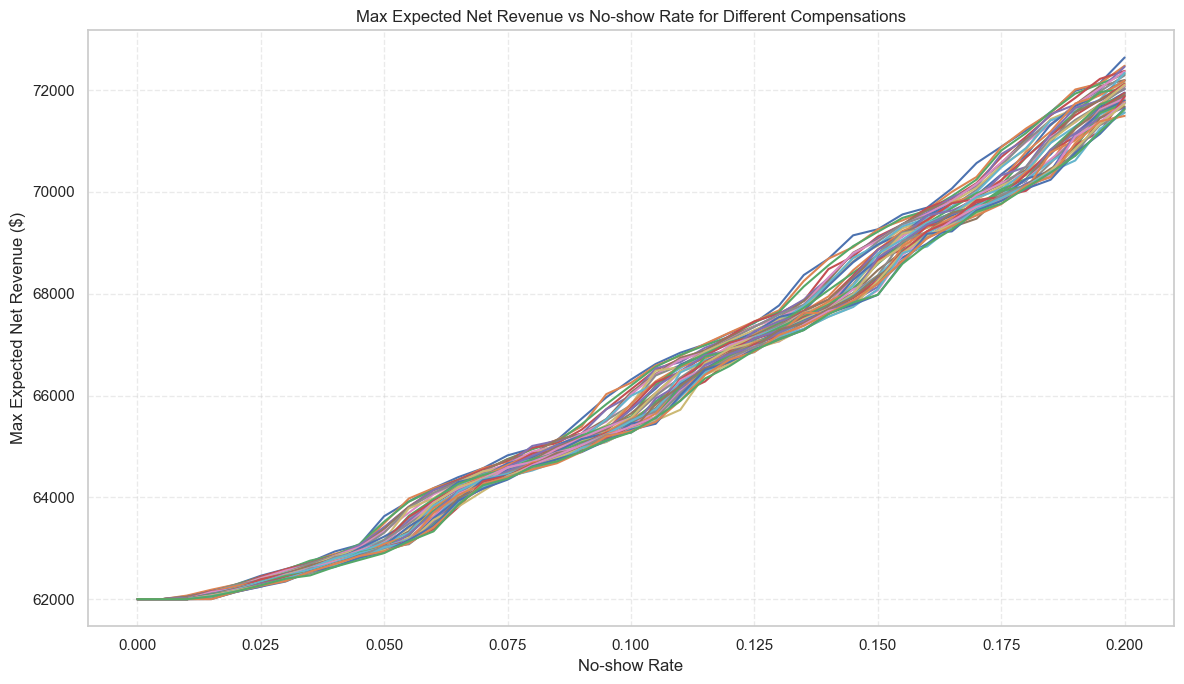

In [75]:
plt.figure(figsize=(12, 7))

# Loop over compensation values
for compensation in compensations_to_test:
    revenue_for_compensation = df[df['compensation_($)'] == compensation]
    plt.plot(revenue_for_compensation['no-show_rate'], revenue_for_compensation['max_expected_net_revenue_($)'], label=f'Compensation = ${compensation}')

plt.title('Max Expected Net Revenue vs No-show Rate for Different Compensations')
plt.xlabel('No-show Rate')
plt.ylabel('Max Expected Net Revenue ($)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

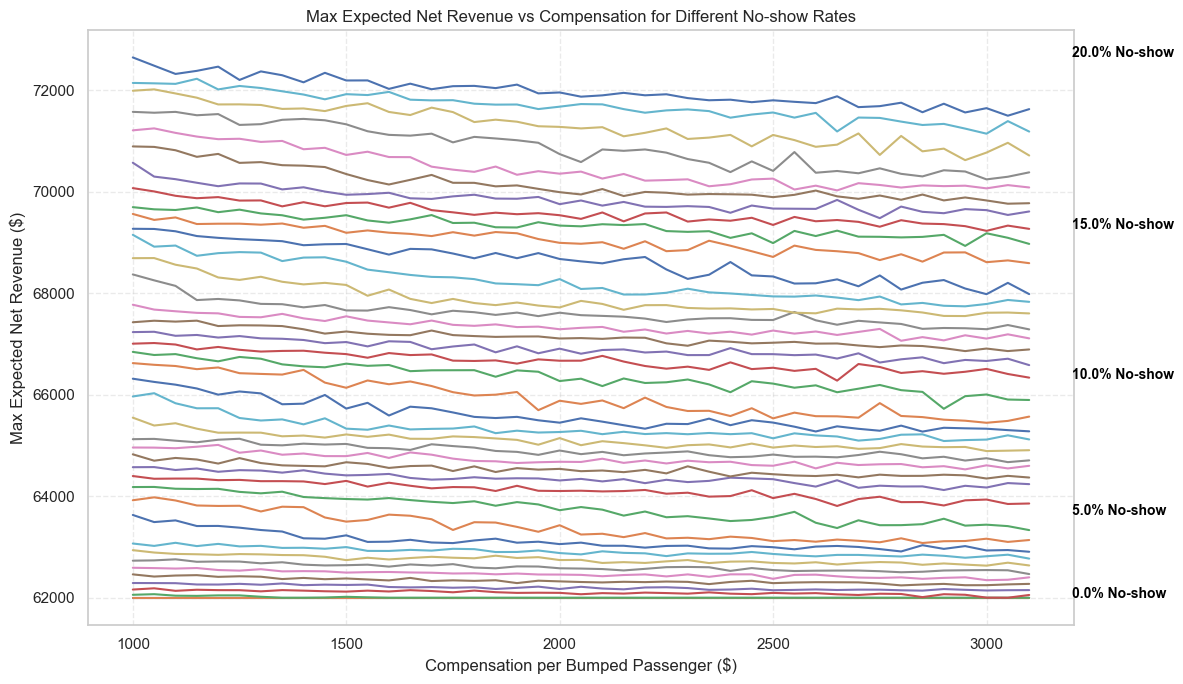

In [76]:
plt.figure(figsize=(12, 7))

# Loop over no-show rates and plot each line
for no_show_rate in no_show_rates_to_test:
    revenue_for_no_show_rate = df[df['no-show_rate'] == no_show_rate]
    line, = plt.plot(revenue_for_no_show_rate['compensation_($)'], revenue_for_no_show_rate['max_expected_net_revenue_($)'])

# Manually add text labels to selected no-show rates at the right end of each line
highlight_no_show_rates = [0.00, 0.05, 0.10, 0.15, 0.20]  # For example, label 5% and 10% no-show rates
for no_show_rate in highlight_no_show_rates:
    revenue_for_no_show_rate = df[df['no-show_rate'] == no_show_rate]
    max_revenue = revenue_for_no_show_rate['max_expected_net_revenue_($)'].max()
    # Find the corresponding compensation for the max revenue
    best_compensation = revenue_for_no_show_rate[revenue_for_no_show_rate['max_expected_net_revenue_($)'] == max_revenue]['compensation_($)'].values[0]
    
    # Find the last compensation value for this no-show rate
    last_compensation = revenue_for_no_show_rate['compensation_($)'].iloc[-1]
    # Place the label slightly to the right of the last compensation value
    plt.text(last_compensation + 100, max_revenue, f'{no_show_rate*100}% No-show', color='black', fontsize=10, weight='bold')

# Title and labels
plt.title('Max Expected Net Revenue vs Compensation for Different No-show Rates')
plt.xlabel('Compensation per Bumped Passenger ($)')
plt.ylabel('Max Expected Net Revenue ($)')

# Grid and layout adjustments
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()